**workshop :(**

data loading

In [25]:
import os
import gzip
import tempfile

def extract_time_series(file_path, sensor_name):
    time_series = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        # Skip the header (first 4 lines)
        for line in lines[4:]:
            parts = line.split()
            if parts[2] != 'chan' and parts[1] == sensor_name:
                # Extract sample number and sensor value
                # sample_number = int(parts[2])
                sensor_value = float(parts[3])
                # time_series.append((sample_number, sensor_value))
                time_series.append(sensor_value)
    return time_series

def process_gz_folder(gz_folder_path, sensor_name):
    sensor_data = {}
    for file_name in os.listdir(gz_folder_path):
        gz_path = os.path.join(gz_folder_path, file_name)
        if os.path.isfile(gz_path) and file_name.endswith('.gz'):
            # Determine the type from the file name (4th letter)
            subject_type = file_name[3]  # 'a' for alcoholic, 'c' for control
            
            # Create a temporary file for decompression
            with tempfile.NamedTemporaryFile(delete=False) as temp_file:
                with gzip.open(gz_path, 'rt') as gz_file:
                    temp_file.write(gz_file.read().encode())  # Decompress and save to temp file
                temp_file_path = temp_file.name
            
            # Extract time series from the decompressed file
            time_series = extract_time_series(temp_file_path, sensor_name)
            
            # Store time series with the associated type - dictionary
            sensor_data[file_name] = {
                'type': subject_type,
                'time_series': time_series
            }
            
            # Clean up the temporary file
            os.remove(temp_file_path)
    return sensor_data

# Example usage
gz_folder_path = "data/SMNI_CMI_TRAIN"  # Replace with your folder containing .gz files
sensor_name = 'CPZ'
all_sensor_data = process_gz_folder(gz_folder_path, sensor_name)

# Output the extracted data
for gz_name, data in all_sensor_data.items():
    print(f"Data from {gz_name} (Type: {data['type']}):")
    print('***')
    print(data['time_series'])
    print('***')
    # for sample_number, sensor_value in data['time_series'][:10]:  # Print first 10 samples for each file
    #     print(f"  Sample {sample_number}: {sensor_value}")
    # print()


Data from co2a0000364.rd.000.gz (Type: a):
***
[-0.478, -0.966, -0.966, -0.966, -0.478, 0.01, 0.01, -0.478, -1.455, -1.455, -1.455, -0.966, 0.01, 0.498, 0.498, -0.478, -0.478, -0.478, 0.01, 0.498, 0.987, 0.498, -0.478, -1.455, -1.455, -0.478, 0.498, 1.475, 1.475, 0.498, -0.478, -1.455, -1.943, -1.943, -1.943, -2.431, -3.408, -3.896, -3.408, -3.408, -2.92, -2.92, -3.408, -3.896, -3.896, -2.92, -1.943, -0.966, -0.966, -1.943, -2.431, -2.92, -2.431, -2.431, -2.431, -2.92, -2.92, -1.943, -1.455, -1.455, -1.943, -2.431, -2.431, -1.455, -0.478, 0.01, 0.498, 0.01, -0.478, -0.478, 0.01, 0.01, 0.01, -0.478, -0.478, 0.498, 0.498, 0.987, 0.987, 1.475, 1.963, 2.452, 2.94, 2.452, 1.963, 1.963, 1.963, 2.452, 2.94, 2.94, 1.963, 1.475, 1.475, 1.963, 2.452, 2.94, 2.94, 2.452, 1.963, 3.428, 4.405, 5.381, 5.381, 4.893, 4.405, 4.405, 4.405, 4.405, 3.916, 2.452, 1.475, 0.498, 0.987, 1.475, 1.475, 1.475, 1.475, 1.963, 2.452, 2.94, 2.94, 2.94, 2.452, 2.452, 2.94, 2.94, 1.963, 0.987, 0.498, 0.498, 1.475, 1.96

time series preprocessing

In [26]:
from PyEMD import EMD
import numpy as np
import matplotlib.pyplot as plt
from gtda.time_series import SingleTakensEmbedding

# Function to apply EMD and denoise the signal
def denoise_signal(signal, num_imfs=3):
    emd = EMD()
    imfs = emd(signal)
    if len(imfs) == 0:
        return signal
    return sum(imfs[-num_imfs-1:])

def takens_embedding(series, m=2, tau=10):
    """Reconstruct the phase space using Takens' embedding theorem."""
    embedded = SingleTakensEmbedding(parameters_type="fixed", dimension=m, time_delay=tau, n_jobs=-1).fit_transform(series)
    return embedded

def plot_time_series_and_attractor(signal, filtered_signal, embedded_data, subject_id):
    """Plot the original time series, the filtered time series, and its Takens embedding attractor."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot time series
    axes[0].plot(signal, label="Time Series", color="blue", linewidth=1)
    axes[0].set_title(f"Time Series (Subject type {subject_id})")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Sensor Value")
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot filtered time series
    axes[1].plot(filtered_signal, label="Filtered Time Series", color="red", linewidth=1)
    axes[1].set_title(f"Filtered Time Series (Subject type {subject_id})")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Sensor Value")
    axes[1].legend()
    axes[1].grid(True)

    # Adjust attractor data scaling for better visibility
    embedded_data_normalized = (embedded_data - np.min(embedded_data, axis=0)) / (
        np.max(embedded_data, axis=0) - np.min(embedded_data, axis=0)
    )

    # Plot attractor in 2D
    axes[2].plot(
        embedded_data_normalized[:, 0],
        embedded_data_normalized[:, 1],
        label="Attractor",
        color="green",
        linewidth=1,
    )
    axes[2].set_xlabel("Dimension 1 (scaled)")
    axes[2].set_ylabel("Dimension 2 (scaled)")

    axes[2].set_title(f"Phase Space (Subject type {subject_id})")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


lazy witness complex

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import gudhi

def maxmin_landmark_selection(data, num_landmarks):
    """Select landmarks using the maxmin algorithm."""
    # Randomly select the first landmark
    landmarks = [data[np.random.choice(len(data))]]

    for _ in range(1, num_landmarks):
        # Compute the minimum distance from each point to the selected landmarks
        distances = np.array([
            min(np.linalg.norm(point - landmark) for landmark in landmarks)
            for point in data
        ])

        # Select the point with the maximum of the minimum distances
        next_landmark = data[np.argmax(distances)]
        landmarks.append(next_landmark)

    return np.array(landmarks)

def witness_complex(data, landmarks_ratio=0.1, max_dim=3):
    witnesses = data
    # landmarks = gudhi.pick_n_random_points(points=witnesses, nb_points=len(data)*landmarks_ratio)
    landmarks = maxmin_landmark_selection(data, num_landmarks=int(len(data)*landmarks_ratio))

    witness_complex = gudhi.EuclideanWitnessComplex(witnesses=witnesses, landmarks=landmarks)
    simplex_tree = witness_complex.create_simplex_tree(max_alpha_square=1,limit_dimension=max_dim)
    return simplex_tree

def plot_persistent_diagram(simplex_tree, subject):
    """Plot the persistence diagram and barcode for the given subject."""
    diagram = simplex_tree.persistence()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot persistence diagram
    gudhi.plot_persistence_diagram(diagram, axes=axes[0])
    axes[0].set_title(f"Persistence Diagram (Subject type {subject})")

    # Plot persistence barcode
    gudhi.plot_persistence_barcode(diagram, axes=axes[1])
    axes[1].set_title(f"Persistence Barcode (Subject type {subject})")

    plt.tight_layout()
    plt.show()


features

In [28]:
def extract_features(diagram, ratio=0.1):
    """Extract topological features from the persistence diagram."""
    features = []
    for dim in [0, 1, 2]:
        lifetimes = [p[1][1] - p[1][0] for p in diagram if p[0] == dim and p[1][1] != float('inf')]
        if lifetimes:
            max_lifetime = max(lifetimes)
            relevant_holes = sum(1 for lifetime in lifetimes if lifetime >= ratio * max_lifetime)
            features.extend([
                len(lifetimes),          # Number of holes
                max_lifetime,            # Maximum lifetime
                relevant_holes,          # Number of relevant holes
                np.mean(lifetimes),      # Average lifetime
                np.sum(lifetimes),       # Total lifetime
            ])
        else:
            features.extend([0, 0, 0, 0, 0])  # Handle empty cases
    return features

In [29]:
from tqdm import tqdm

features = []
labels = []

for gz_name, data in tqdm(all_sensor_data.items()):
    signal = np.array(data['time_series'])
    subject_id = 1 if data['type'] == "a" else 0 # 1 for alcoholic, 0 for control
    labels.append(subject_id)
    filtered_signal = denoise_signal(signal)
    embedded_data = takens_embedding(filtered_signal)
    # plot_time_series_and_attractor(signal, filtered_signal, embedded_data, subject_id)
    simplex_tree = witness_complex(embedded_data)
    # plot_persistent_diagram(simplex_tree,subject_id)
    subject_features = extract_features(simplex_tree.persistence())
    features.append(subject_features)

100%|██████████| 600/600 [02:12<00:00,  4.53it/s]


clustering

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import seaborn as sns

def cluster_and_evaluate(features, labels):
    """Perform clustering and evaluate against ground truth labels."""
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=2, random_state=42)
    predicted_labels = kmeans.fit_predict(scaled_features)
    
    accuracy = accuracy_score(labels, predicted_labels)
    precision = precision_score(labels, predicted_labels)
    recall = recall_score(labels, predicted_labels)
    f1 = f1_score(labels, predicted_labels)
    mathews_corrcoef = matthews_corrcoef(labels, predicted_labels)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Mathews Correlation Coefficient: {mathews_corrcoef:.2f}")
    
    print(classification_report(labels, predicted_labels))
    
    cm = confusion_matrix(labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    return predicted_labels

C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Accuracy: 0.50
Precision: 0.25
Recall: 0.00
F1 Score: 0.01
Mathews Correlation Coefficient: -0.04
              precision    recall  f1-score   support

           0       0.50      0.99      0.66       300
           1       0.25      0.00      0.01       300

    accuracy                           0.50       600
   macro avg       0.37      0.50      0.33       600
weighted avg       0.37      0.50      0.33       600



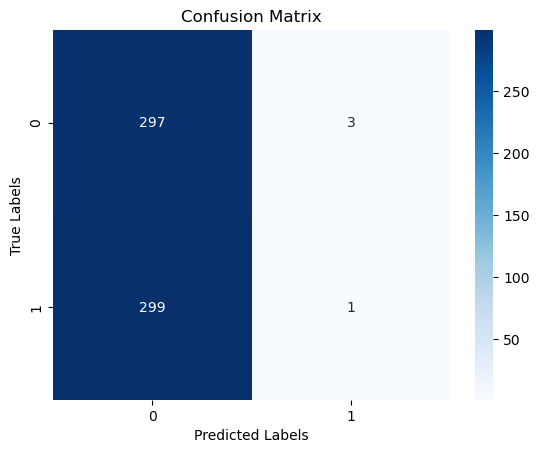

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [31]:
# Cluster and evaluate
features = np.array(features)
labels = np.array(labels)
cluster_and_evaluate(features, labels)